In [ ]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import seaborn as sns
import re
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
data = pd.read_csv('dataset.csv')
data.head()

,index,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Target
0,1,-1,1,1,1,-1,-1,-1,-1,-1,...,1,1,-1,-1,-1,-1,1,1,-1,0
1,2,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,0
2,3,1,0,1,1,1,-1,-1,-1,-1,...,1,1,1,-1,1,-1,1,0,-1,0
3,4,1,0,1,1,1,-1,-1,-1,1,...,1,1,-1,-1,1,-1,1,-1,1,0
4,5,1,0,-1,1,1,-1,1,1,-1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [ ]:
data.columns

Index(['index', 'having_IPhaving_IP_Address', 'URLURL_Length',
       'Shortining_Service', 'having_At_Symbol', 'double_slash_redirecting',
       'Prefix_Suffix', 'having_Sub_Domain', 'SSLfinal_State',
       'Domain_registeration_length', 'Favicon', 'port', 'HTTPS_token',
       'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'SFH',
       'Submitting_to_email', 'Abnormal_URL', 'Redirect', 'on_mouseover',
       'RightClick', 'popUpWidnow', 'Iframe', 'age_of_domain', 'DNSRecord',
       'web_traffic', 'Page_Rank', 'Google_Index', 'Links_pointing_to_page',
       'Statistical_report', 'Target'],
      dtype='object')

In [ ]:
def extract_url_features(url):
    parsed_url = urlparse(url)
    features = {
        "has_ip": 1 if re.search(r"\d+\.\d+\.\d+\.\d+", url) else -1,
        "url_length": len(url),
        "shortened": 1 if "bit.ly" in url or "tinyurl.com" in url else -1,
        "has_at_symbol": 1 if "@" in url else -1,
        "double_slash": 1 if url.count("//") > 1 else -1,
        "prefix_suffix": 1 if "-" in parsed_url.netloc else -1,
        "sub_domain": 1 if parsed_url.netloc.count(".") > 2 else -1,
        "ssl_state": 1 if parsed_url.scheme == "https" else -1,
        "domain_age": -1,
        "favicon": -1,
        "port_status": -1,
        "https_token": 1 if "https" in parsed_url.netloc else -1,
        "request_url": -1,
        "anchor_url": -1,
        "links_in_tags": -1,
        "sfh": -1,
        "submit_email": -1,
        "abnormal_url": -1,
        "redirects": url.count("//"),
        "on_mouseover": -1,
        "right_click": -1,
        "popup_window": -1,
        "iframe": -1,
        "domain_validity": -1,
        "dns_record": -1,
        "web_traffic": -1,
        "page_rank": -1,
        "google_index": -1,
        "links_pointing": -1,
        "stat_report": -1
    }
    return features

In [ ]:
def scrape_url(url):
    try:
        response = requests.get(url, timeout=5)
        soup = BeautifulSoup(response.text, 'html.parser')
        features = extract_url_features(url)
        features['num_links'] = len(soup.find_all('a'))
        features_df = pd.DataFrame([features])

        # Ensure the order and columns match the training feature names
        features_df = features_df[features_df.columns[features_df.columns.isin(data.columns)]]
        return features_df
    except Exception as e:
        print(f"Error scraping the URL: {e}")
        return None

In [ ]:
X = data[important_features]
y = data['Target']

In [ ]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, stratify=y_resampled, test_size=0.25, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

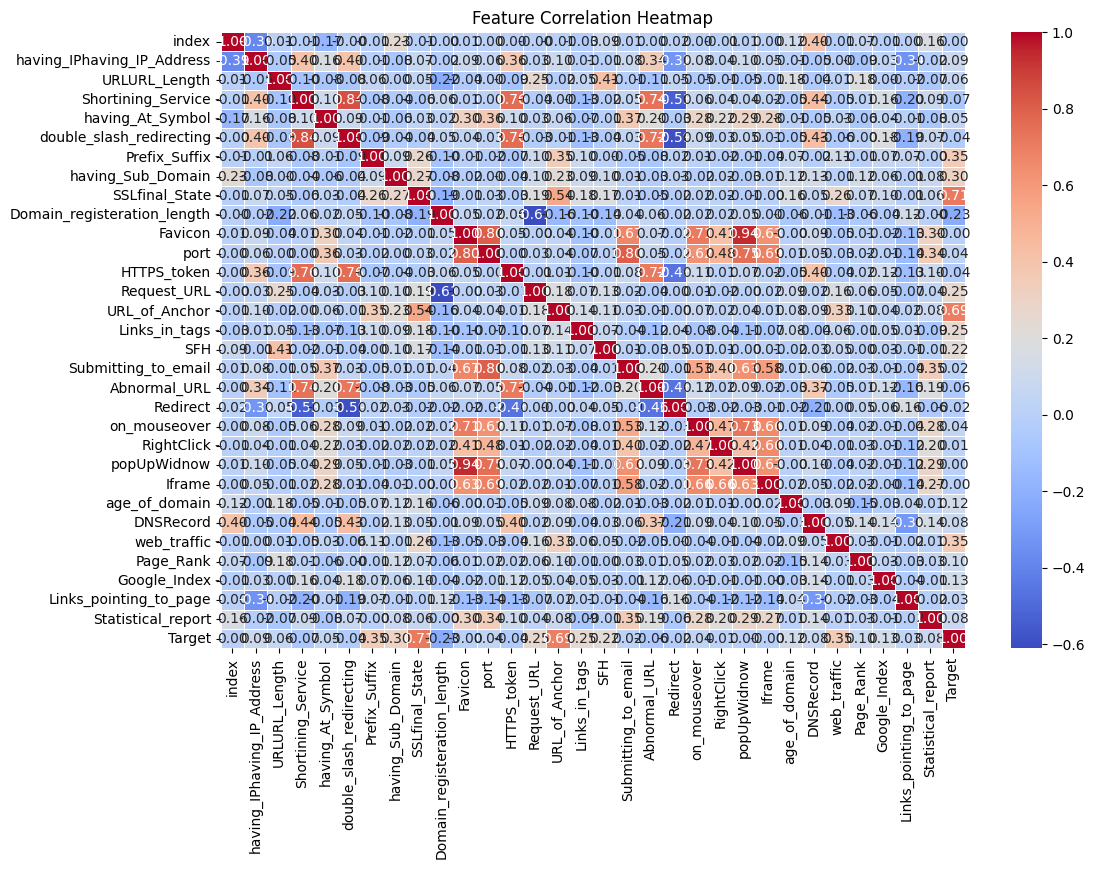

Most important features for classification: ['SSLfinal_State', 'URL_of_Anchor', 'Prefix_Suffix', 'web_traffic', 'having_Sub_Domain', 'Request_URL', 'Links_in_tags', 'Domain_registeration_length', 'SFH']


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()
target_correlation = correlation_matrix["Target"].abs().sort_values(ascending=False)
important_features = target_correlation[target_correlation > 0.2].index.tolist()
important_features.remove("Target")
print("Most important features for classification:", important_features)

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Decision Tree': DecisionTreeClassifier(),
    'XGBoost': XGBClassifier()
}

In [ ]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1_Score': f1_score(y_test, y_pred)
    }

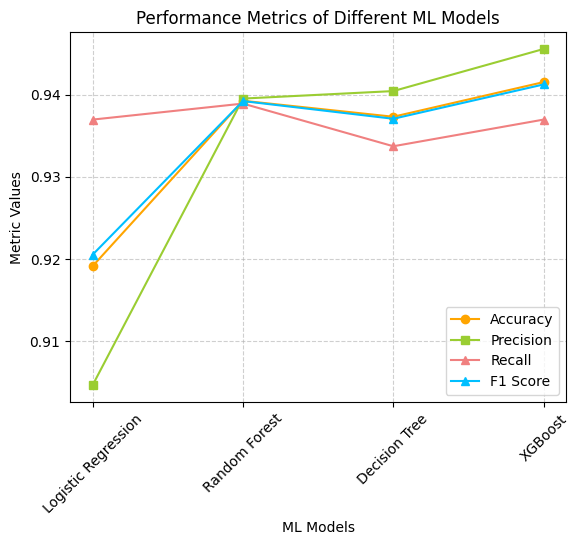

In [ ]:
models = list(results.keys())
accuracy_values = [results[m]['Accuracy'] for m in models]
precision_values = [results[m]['Precision'] for m in models]
recall_values = [results[m]['Recall'] for m in models]
f1=[results[m]['F1_Score'] for m in models]
plt.plot(models, accuracy_values, marker='o', linestyle='-', color='orange', label='Accuracy')
plt.plot(models, precision_values, marker='s', linestyle='-', color='yellowgreen', label='Precision')
plt.plot(models, recall_values, marker='^', linestyle='-', color='lightcoral', label='Recall')
plt.plot(models, f1, marker='^', linestyle='-', color='deepskyblue', label='F1 Score')
plt.xlabel("ML Models")
plt.ylabel("Metric Values")
plt.title("Performance Metrics of Different ML Models")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

In [ ]:
dnn_model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Stop training if no improvement for 10 epochs
    restore_best_weights=True
)

In [ ]:
dnn_history = dnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    verbose=1,
    callbacks=[early_stopping]  # Add callback here
)

Epoch 1/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8417 - loss: 0.3798 - val_accuracy: 0.9253 - val_loss: 0.1865
Epoch 2/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9163 - loss: 0.2064 - val_accuracy: 0.9266 - val_loss: 0.1716
Epoch 3/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9265 - loss: 0.1888 - val_accuracy: 0.9289 - val_loss: 0.1639
Epoch 4/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9264 - loss: 0.1749 - val_accuracy: 0.9302 - val_loss: 0.1592
Epoch 5/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9300 - loss: 0.1699 - val_accuracy: 0.9311 - val_loss: 0.1574
Epoch 6/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9329 - loss: 0.1604 - val_accuracy: 0.9311 - val_loss: 0.1552
Epoch 7/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9289 - loss: 0.1653 - val_accuracy: 0.9321 - val_loss: 0.1493
Epoch 8/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9313 - loss: 0.1587 - val_ac

In [ ]:
dnn_results = {
    'Accuracy': dnn_history.history['val_accuracy'][-1],
    'Precision': precision_score(y_test, (dnn_model.predict(X_test) > 0.5)),
    'Recall': recall_score(y_test, (dnn_model.predict(X_test) > 0.5)),
    'F1 Score': f1_score(y_test, (dnn_model.predict(X_test) > 0.5)),
}
print(dnn_results)
results['Deep Learning'] = dnn_results

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
{'Accuracy': 0.9408898949623108, 'Precision': 0.9438275636838668, 'Recall': 0.9389213775178687, 'F1 Score': 0.9413680781758957}


Text(0.5, 1.0, 'Loss Curve')

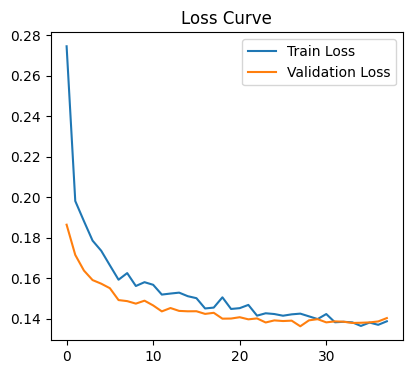

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(dnn_history.history['loss'], label='Train Loss')
plt.plot(dnn_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curve')

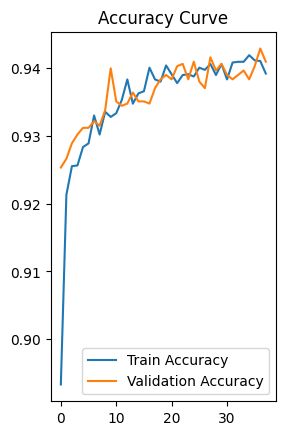

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(dnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(dnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

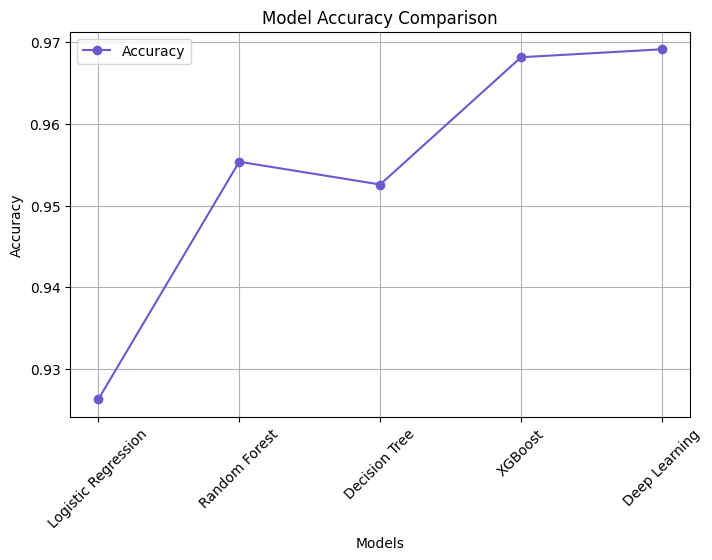

In [ ]:
import matplotlib.pyplot as plt
models = ["Logistic Regression", "Random Forest", "Decision Tree", "XGBoost", "Deep Learning"]
accuracy_scores = [0.926275, 0.9553693, 0.952582, 0.968171, 0.969146]
plt.figure(figsize=(8, 5))
plt.plot(models, accuracy_scores, marker='o', linestyle='-', color='slateblue', label='Accuracy')
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
def predict_url(url):
    features_df = scrape_url(url)
    if features_df is None:
        return "Invalid or inaccessible URL"
    features_scaled = scaler.transform(features_df)

    # Make prediction using the deep learning model
    prediction = dnn_model.predict(features_scaled)

    return "Phishing" if prediction[0][0] > 0.5 else "Legitimate"

In [ ]:
def predict_url(url):
    features_df = scrape_url(url)
    if features_df is None:
        return "Invalid or inaccessible URL"
    features_df = features_df[[col for col in important_features if col in features_df.columns]]
    features_df = features_df.reindex(columns=important_features, fill_value=-1)
    features_scaled = scaler.transform(features_df)
    prediction = dnn_model.predict(features_scaled)
    return "Phishing" if prediction[0][0] > 0.5 else "Legitimate"


In [ ]:
user_url = input("Enter a URL to check if it's phishing or legitimate: ")
print(f"The URL is classified as: {predict_url(user_url)}")

Enter a URL to check if it's phishing or legitimate: https://bvrit.edu.in
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
The URL is classified as: Legitimate
